In [18]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [19]:

# chr1	hg38_ncbiRefSeq	stop_codon	67093005	67093007	0.000000	-	.	gene_id "XM_011541469.1"; transcript_id "XM_011541469.1";

names = ["chr","genome","type","start","stop","zero","strand","dot","info"]

f1 = "hg38_refseq.gtf"
df  = pd.read_csv(f1,sep="\t",names=names)
df = df[~df["chr"].str.contains("_")] # Get rid of patched chr
# df = df.iloc[0:100_000]

print(df.head())

df["geneid"] = df["info"].str.split(pat=";", expand=True)[0]#[0]#.split("\"")[1]
df["geneid"] = df["geneid"].str.split(pat="\"", expand=True)[1]#[0]#.split("\"")[1]

# Remove these long transcripts
df = df[~df["geneid"].str.contains("XR_")] # Get rid of patched chr
df = df[~df["geneid"].str.contains("XM_")] # Get rid of patched chr

df_txstart = df.sort_values(ascending=True, by="start").drop_duplicates(subset="geneid", keep='first')
df_txend   = df.sort_values(ascending=False, by="stop").drop_duplicates(subset="geneid", keep='first')
df_txend["txEnd_ALL"] = df_txend[["stop"]] #Keep only the end
df_txend = df_txend[["geneid","txEnd_ALL"]] #Keep only the end
print("before merge",len(df))
df = pd.merge(df_txstart,df_txend,how='inner',left_on='geneid',right_on="geneid")
print("after merge",len(df))
del df["stop"]
df.rename(columns={"txEnd_ALL":"stop"},inplace=True)


# Sort by longest end then drop same starts
df = df.sort_values(ascending=False, by=["stop","chr"])
df = df.drop_duplicates(subset=["chr","start"], keep='first')

df = df.sort_values(ascending=True, by=["start","chr"])
df = df.drop_duplicates(subset=["chr","stop"], keep='first')

df["length"] =  df["stop"] - df["start"]
df["type"] = "exon"
print("length df: ", df)



    chr           genome        type     start      stop  zero strand dot  \
0  chr1  hg38_ncbiRefSeq  stop_codon  67093005  67093007   0.0      -   .   
1  chr1  hg38_ncbiRefSeq         CDS  67093008  67093604   0.0      -   0   
2  chr1  hg38_ncbiRefSeq        exon  67092176  67093604   0.0      -   .   
3  chr1  hg38_ncbiRefSeq         CDS  67095235  67095421   0.0      -   1   
4  chr1  hg38_ncbiRefSeq        exon  67095235  67095421   0.0      -   .   

                                                info  
0  gene_id "XM_011541469.1"; transcript_id "XM_01...  
1  gene_id "XM_011541469.1"; transcript_id "XM_01...  
2  gene_id "XM_011541469.1"; transcript_id "XM_01...  
3  gene_id "XM_011541469.1"; transcript_id "XM_01...  
4  gene_id "XM_011541469.1"; transcript_id "XM_01...  
before merge 1266133
after merge 65484
length df:           chr           genome  type      start  zero strand dot  \
0       chrM  hg38_ncbiRefSeq  exon       3307   0.0      +   .   
1       chrM  hg38_ncb

In [20]:
df.head()

,chr,genome,type,start,zero,strand,dot,info,geneid,stop,length
0,chrM,hg38_ncbiRefSeq,exon,3307,0.0,+,.,"gene_id ""YP_003024026.1""; transcript_id ""YP_00...",YP_003024026.1,4262,955
1,chrM,hg38_ncbiRefSeq,exon,4470,0.0,+,0,"gene_id ""YP_003024027.1""; transcript_id ""YP_00...",YP_003024027.1,5511,1041
2,chrM,hg38_ncbiRefSeq,exon,5904,0.0,+,.,"gene_id ""YP_003024028.1""; transcript_id ""YP_00...",YP_003024028.1,7445,1541
3,chrM,hg38_ncbiRefSeq,exon,7586,0.0,+,.,"gene_id ""YP_003024029.1""; transcript_id ""YP_00...",YP_003024029.1,8269,683
4,chrM,hg38_ncbiRefSeq,exon,8366,0.0,+,.,"gene_id ""YP_003024030.1""; transcript_id ""YP_00...",YP_003024030.1,8572,206


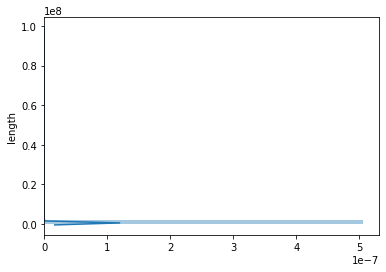

In [21]:
# Length distribution of transcripts

ax = sns.distplot(df["length"], vertical=True)

In [22]:
df_over250kb = df[df["length"]>250_000]
df_over250kb.head()

,chr,genome,type,start,zero,strand,dot,info,geneid,stop,length
141,chr9,hg38_ncbiRefSeq,exon,214865,0.0,+,.,"gene_id ""NM_203447.3""; transcript_id ""NM_20344...",NM_203447.3,465259,250394
194,chr10,hg38_ncbiRefSeq,exon,274190,0.0,-,.,"gene_id ""NM_014974.2""; transcript_id ""NM_01497...",NM_014974.2,689668,415478
317,chr9,hg38_ncbiRefSeq,exon,470291,0.0,+,.,"gene_id ""NM_001256876.2""; transcript_id ""NM_00...",NM_001256876.2,746106,275815
438,chr3,hg38_ncbiRefSeq,exon,592105,0.0,+,.,"gene_id ""NR_110118.1""; transcript_id ""NR_11011...",NR_110118.1,846015,253910
624,chr8,hg38_ncbiRefSeq,exon,737605,0.0,+,.,"gene_id ""NR_073397.1""; transcript_id ""NR_07339...",NR_073397.1,1137777,400172


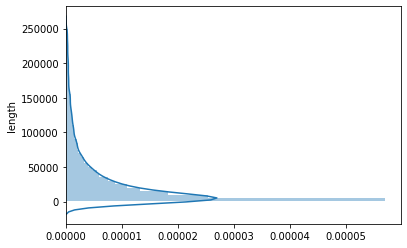

In [23]:
df_under250kb = df[df["length"]<250_000]
ax = sns.distplot(df_under250kb["length"], vertical=True)

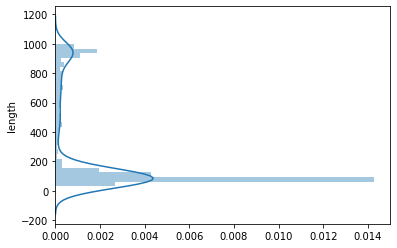

In [24]:
df_under1kb = df[df["length"]<1000]
ax = sns.distplot(df_under1kb["length"], vertical=True)

In [25]:
def get_strand_chr_dic(df_gtf, plu_or_min):

    """This function will take a gtf and return strand specific dictionary of different chrm"""

    #Make positive and negative strand dictionary of dataframe
    
    df_plu_or_min = df_gtf[df_gtf["strand"]==plu_or_min]
    chr_names=df_gtf['chr'].unique().tolist()
    d_gtf_chr = {chrom : df_plu_or_min.loc[df_plu_or_min.chr==chrom] for chrom in chr_names}
    return d_gtf_chr
d_plu = get_strand_chr_dic(df, "+")
d_min = get_strand_chr_dic(df, "-")

df_plu = df[df["strand"]=="+"]
df_min = df[df["strand"]=="-"]

In [26]:

def check_duplicate(df,strand):
    df = df.copy()
    df["info"] = df["info"]+" gene_name \""+df["geneid"]+'\"; gene_biotype \"null\";'
    df["info"].iloc[0] = df["info"].iloc[0].replace("null","null1")
    df["duplicate"] = (df["start"] == df["start"].shift(-1)) & (df["start"] == df["start"].shift(-1))

    # print("length of df", len(df))
    df = df[df["duplicate"] != True]
    # print("length after removing similar coordinates", len(df))
    del df["duplicate"]
    
    df["length"] = df["stop"] - df["start"]
    df = df[df["length"] < 1_000_000]  #Filter out genes over a million base pairs
    # print("length after removing genes over 1,000,000bp", len(df))
    
    def remove_inside_genes(df):
        df["ig"] = ( df["start"].shift(1) <= df["start"] ) & ( df["stop"] <= df["stop"].shift(1) )
        count = df["ig"].sum()
        while count > 0:
            df = df[df["ig"] != True]
            df["ig"] = ( df["start"].shift(1) <= df["start"] ) & ( df["stop"] <= df["stop"].shift(1) )  
            count = df["ig"].sum()
        del df["ig"]
        return df
        
    
    if strand == "+":        
        df = df.sort_values(by="start")
        
        df = remove_inside_genes(df)        
        df["ROL"] = df["stop"] >= df["start"].shift(-1) # ROL is right overlap
        df["c"] = (df["ROL"] == True) & (df["ROL"].shift(1) == True) & (df["ROL"].shift(-1) == True) # genes that are clustered overlap. Have TRUE above and Below and are true themselves
    
        df = remove_inside_genes(df)
    
        df = df[df["c"]!=True] # Remove genes that are clustered
        df = remove_inside_genes(df)
        df["c2"] = (df["ROL"] == True) & (df["ROL"].shift(1) == True)  
        df = df[df["c2"]!=True] # Remove genes that are clustered
        df = remove_inside_genes(df)
        df["newstop"] = np.where(df["ROL"]==True, df["stop"].shift(-1), df["stop"])
        df["c3"] = (df["ROL"] == False) & (df["ROL"].shift(1) == True) 
        df = df[df["c3"]!=True] # Remove genes that are clustered
        df = remove_inside_genes(df)
        df["distance"] = df["start"].shift(-1) - df["newstop"]
        df["stop"] = np.where(df["stop"] > df["newstop"] , df["stop"], df["newstop"])
        df = df.sort_values(by="start")
        
    if strand == "-":
        df = df.sort_values(by="stop",ascending=False)
        df = remove_inside_genes(df)        
        df["LOL"] = df["start"] <= df["stop"].shift(-1) # LOL is left overlap
        df["c"] = (df["LOL"] == True) & (df["LOL"].shift(1) == True) & (df["LOL"].shift(-1) == True) # genes that are clustered overlap. Have
        #  TRUE above and Below and are true themselves
        df = remove_inside_genes(df)
        df = df[df["c"] != True] # Remove genes that are clustered
        df = remove_inside_genes(df)
        df["distance"] = df["start"] - df["stop"].shift(-1) # LOL is left overlap
        #Remove inside genes again
        df["c2"] = (df["LOL"] == True) & (df["LOL"].shift(1) == True)  
        df = df[df["c2"]!=True] # Remove genes that are clustered
        df = remove_inside_genes(df)
        df["newstart"] = np.where(df["LOL"]==True, df["start"].shift(-1), df["start"])
        df["c3"] = (df["LOL"] == False) & (df["LOL"].shift(1) == True) 
        df = df[df["c3"]!=True] # Remove genes that are clustered
        df = remove_inside_genes(df)
        df["start"] = np.where(df["start"] < df["newstart"] , df["start"], df["newstart"])
        df["distance"] = df["start"] - df["stop"].shift(-1) # LOL is left overlap
        df = df.sort_values(by="start")
        
    return df

# dfcd = check_duplicate(df_plu, "+")
# dfcd = check_duplicate(d_plu["2"], "+")
# dfcd = check_duplicate(d_min["2"], "-")
# dfcd.head(100)

print("length of df", len(df))
print(list(df))



df_final = pd.DataFrame()
for chrom in df['chr'].unique().tolist():
    print("working on chr: ", chrom)
    dfchrplu = check_duplicate(d_plu[chrom], "+")
    dfchrmin = check_duplicate(d_min[chrom], "-")
    df_final = df_final.append(dfchrplu)
    df_final = df_final.append(dfchrmin)

df_final["start"] = df_final["start"].astype(int)
df_final["stop"] = df_final["stop"].astype(int)

print("length of df after removing duplicates and overlaps", len(df_final))

length of df 28449
['chr', 'genome', 'type', 'start', 'zero', 'strand', 'dot', 'info', 'geneid', 'stop', 'length']
working on chr:  chrM
working on chr:  chr16
working on chr:  chr18
working on chr:  chr10
working on chr:  chr3
working on chr:  chr1
working on chr:  chr9
working on chr:  chr12
working on chr:  chr2
working on chr:  chr4
working on chr:  chr19
working on chr:  chr20
working on chr:  chr5
working on chr:  chr11
working on chr:  chr17
working on chr:  chr6
working on chr:  chr7
working on chr:  chr8
working on chr:  chrY
working on chr:  chrX
working on chr:  chr21
working on chr:  chr22
working on chr:  chr13
working on chr:  chr14
working on chr:  chr15
length of df after removing duplicates and overlaps 25531


In [27]:
df.head()

,chr,genome,type,start,zero,strand,dot,info,geneid,stop,length
0,chrM,hg38_ncbiRefSeq,exon,3307,0.0,+,.,"gene_id ""YP_003024026.1""; transcript_id ""YP_00...",YP_003024026.1,4262,955
1,chrM,hg38_ncbiRefSeq,exon,4470,0.0,+,0,"gene_id ""YP_003024027.1""; transcript_id ""YP_00...",YP_003024027.1,5511,1041
2,chrM,hg38_ncbiRefSeq,exon,5904,0.0,+,.,"gene_id ""YP_003024028.1""; transcript_id ""YP_00...",YP_003024028.1,7445,1541
3,chrM,hg38_ncbiRefSeq,exon,7586,0.0,+,.,"gene_id ""YP_003024029.1""; transcript_id ""YP_00...",YP_003024029.1,8269,683
4,chrM,hg38_ncbiRefSeq,exon,8366,0.0,+,.,"gene_id ""YP_003024030.1""; transcript_id ""YP_00...",YP_003024030.1,8572,206


In [28]:
df2 = df


In [30]:
def toEnsembleLike(df, name):
#     df["info"] = df["info"]+" gene_name \""+df["geneid"]+'\"; gene_biotype \"null\";'
#     df["info"].iloc[0] = df["info"].iloc[0].replace("null","null1")
    df["type"] = "gene"
    df["dot2"] = "."
    
    for x in range(len(df)):
        if x % 2:
            print("working on ", x)
            df["info"].iloc[x] = df["info"].iloc[x].replace("null","null1")
        
    df = df[["chr","genome","type","start","stop","dot","strand","dot2","info"]]
    
    df.to_csv(name, sep="\t",index=None, header=None, quoting=csv.QUOTE_NONE)



def toGTF(df, name):
    df = df[names]
    df.to_csv(name, sep="\t",index=None, header=None, quoting=csv.QUOTE_NONE)

def toBED(df,name):
    df = df[["chr","start","stop","strand","info"]]
    df.to_csv(name, sep="\t",index=None, header=None, quoting=csv.QUOTE_NONE)
    
    
toGTF(df=df_final, name="hg38_refseq_longest_transcript_removeinside.gtf")
toEnsembleLike(df=df_final, name="hg38_refseq_EnsembleLIKE.gtf")

working on  1
working on  3
working on  5
working on  7
working on  9
working on  11
working on  13
working on  15
working on  17
working on  19
working on  21
working on  23
working on  25
working on  27
working on  29
working on  31
working on  33
working on  35
working on  37
working on  39
working on  41
working on  43
working on  45
working on  47
working on  49
working on  51
working on  53
working on  55
working on  57
working on  59
working on  61
working on  63
working on  65
working on  67
working on  69
working on  71
working on  73
working on  75
working on  77
working on  79
working on  81
working on  83
working on  85
working on  87
working on  89
working on  91
working on  93
working on  95
working on  97
working on  99
working on  101
working on  103
working on  105
working on  107
working on  109
working on  111
working on  113
working on  115
working on  117
working on  119
working on  121
working on  123
working on  125
working on  127
working on  129
working on  131

working on  1035
working on  1037
working on  1039
working on  1041
working on  1043
working on  1045
working on  1047
working on  1049
working on  1051
working on  1053
working on  1055
working on  1057
working on  1059
working on  1061
working on  1063
working on  1065
working on  1067
working on  1069
working on  1071
working on  1073
working on  1075
working on  1077
working on  1079
working on  1081
working on  1083
working on  1085
working on  1087
working on  1089
working on  1091
working on  1093
working on  1095
working on  1097
working on  1099
working on  1101
working on  1103
working on  1105
working on  1107
working on  1109
working on  1111
working on  1113
working on  1115
working on  1117
working on  1119
working on  1121
working on  1123
working on  1125
working on  1127
working on  1129
working on  1131
working on  1133
working on  1135
working on  1137
working on  1139
working on  1141
working on  1143
working on  1145
working on  1147
working on  1149
working on  11

working on  1999
working on  2001
working on  2003
working on  2005
working on  2007
working on  2009
working on  2011
working on  2013
working on  2015
working on  2017
working on  2019
working on  2021
working on  2023
working on  2025
working on  2027
working on  2029
working on  2031
working on  2033
working on  2035
working on  2037
working on  2039
working on  2041
working on  2043
working on  2045
working on  2047
working on  2049
working on  2051
working on  2053
working on  2055
working on  2057
working on  2059
working on  2061
working on  2063
working on  2065
working on  2067
working on  2069
working on  2071
working on  2073
working on  2075
working on  2077
working on  2079
working on  2081
working on  2083
working on  2085
working on  2087
working on  2089
working on  2091
working on  2093
working on  2095
working on  2097
working on  2099
working on  2101
working on  2103
working on  2105
working on  2107
working on  2109
working on  2111
working on  2113
working on  21

working on  2975
working on  2977
working on  2979
working on  2981
working on  2983
working on  2985
working on  2987
working on  2989
working on  2991
working on  2993
working on  2995
working on  2997
working on  2999
working on  3001
working on  3003
working on  3005
working on  3007
working on  3009
working on  3011
working on  3013
working on  3015
working on  3017
working on  3019
working on  3021
working on  3023
working on  3025
working on  3027
working on  3029
working on  3031
working on  3033
working on  3035
working on  3037
working on  3039
working on  3041
working on  3043
working on  3045
working on  3047
working on  3049
working on  3051
working on  3053
working on  3055
working on  3057
working on  3059
working on  3061
working on  3063
working on  3065
working on  3067
working on  3069
working on  3071
working on  3073
working on  3075
working on  3077
working on  3079
working on  3081
working on  3083
working on  3085
working on  3087
working on  3089
working on  30

working on  3953
working on  3955
working on  3957
working on  3959
working on  3961
working on  3963
working on  3965
working on  3967
working on  3969
working on  3971
working on  3973
working on  3975
working on  3977
working on  3979
working on  3981
working on  3983
working on  3985
working on  3987
working on  3989
working on  3991
working on  3993
working on  3995
working on  3997
working on  3999
working on  4001
working on  4003
working on  4005
working on  4007
working on  4009
working on  4011
working on  4013
working on  4015
working on  4017
working on  4019
working on  4021
working on  4023
working on  4025
working on  4027
working on  4029
working on  4031
working on  4033
working on  4035
working on  4037
working on  4039
working on  4041
working on  4043
working on  4045
working on  4047
working on  4049
working on  4051
working on  4053
working on  4055
working on  4057
working on  4059
working on  4061
working on  4063
working on  4065
working on  4067
working on  40

working on  4917
working on  4919
working on  4921
working on  4923
working on  4925
working on  4927
working on  4929
working on  4931
working on  4933
working on  4935
working on  4937
working on  4939
working on  4941
working on  4943
working on  4945
working on  4947
working on  4949
working on  4951
working on  4953
working on  4955
working on  4957
working on  4959
working on  4961
working on  4963
working on  4965
working on  4967
working on  4969
working on  4971
working on  4973
working on  4975
working on  4977
working on  4979
working on  4981
working on  4983
working on  4985
working on  4987
working on  4989
working on  4991
working on  4993
working on  4995
working on  4997
working on  4999
working on  5001
working on  5003
working on  5005
working on  5007
working on  5009
working on  5011
working on  5013
working on  5015
working on  5017
working on  5019
working on  5021
working on  5023
working on  5025
working on  5027
working on  5029
working on  5031
working on  50

working on  5899
working on  5901
working on  5903
working on  5905
working on  5907
working on  5909
working on  5911
working on  5913
working on  5915
working on  5917
working on  5919
working on  5921
working on  5923
working on  5925
working on  5927
working on  5929
working on  5931
working on  5933
working on  5935
working on  5937
working on  5939
working on  5941
working on  5943
working on  5945
working on  5947
working on  5949
working on  5951
working on  5953
working on  5955
working on  5957
working on  5959
working on  5961
working on  5963
working on  5965
working on  5967
working on  5969
working on  5971
working on  5973
working on  5975
working on  5977
working on  5979
working on  5981
working on  5983
working on  5985
working on  5987
working on  5989
working on  5991
working on  5993
working on  5995
working on  5997
working on  5999
working on  6001
working on  6003
working on  6005
working on  6007
working on  6009
working on  6011
working on  6013
working on  60

working on  6875
working on  6877
working on  6879
working on  6881
working on  6883
working on  6885
working on  6887
working on  6889
working on  6891
working on  6893
working on  6895
working on  6897
working on  6899
working on  6901
working on  6903
working on  6905
working on  6907
working on  6909
working on  6911
working on  6913
working on  6915
working on  6917
working on  6919
working on  6921
working on  6923
working on  6925
working on  6927
working on  6929
working on  6931
working on  6933
working on  6935
working on  6937
working on  6939
working on  6941
working on  6943
working on  6945
working on  6947
working on  6949
working on  6951
working on  6953
working on  6955
working on  6957
working on  6959
working on  6961
working on  6963
working on  6965
working on  6967
working on  6969
working on  6971
working on  6973
working on  6975
working on  6977
working on  6979
working on  6981
working on  6983
working on  6985
working on  6987
working on  6989
working on  69

working on  7855
working on  7857
working on  7859
working on  7861
working on  7863
working on  7865
working on  7867
working on  7869
working on  7871
working on  7873
working on  7875
working on  7877
working on  7879
working on  7881
working on  7883
working on  7885
working on  7887
working on  7889
working on  7891
working on  7893
working on  7895
working on  7897
working on  7899
working on  7901
working on  7903
working on  7905
working on  7907
working on  7909
working on  7911
working on  7913
working on  7915
working on  7917
working on  7919
working on  7921
working on  7923
working on  7925
working on  7927
working on  7929
working on  7931
working on  7933
working on  7935
working on  7937
working on  7939
working on  7941
working on  7943
working on  7945
working on  7947
working on  7949
working on  7951
working on  7953
working on  7955
working on  7957
working on  7959
working on  7961
working on  7963
working on  7965
working on  7967
working on  7969
working on  79

working on  8821
working on  8823
working on  8825
working on  8827
working on  8829
working on  8831
working on  8833
working on  8835
working on  8837
working on  8839
working on  8841
working on  8843
working on  8845
working on  8847
working on  8849
working on  8851
working on  8853
working on  8855
working on  8857
working on  8859
working on  8861
working on  8863
working on  8865
working on  8867
working on  8869
working on  8871
working on  8873
working on  8875
working on  8877
working on  8879
working on  8881
working on  8883
working on  8885
working on  8887
working on  8889
working on  8891
working on  8893
working on  8895
working on  8897
working on  8899
working on  8901
working on  8903
working on  8905
working on  8907
working on  8909
working on  8911
working on  8913
working on  8915
working on  8917
working on  8919
working on  8921
working on  8923
working on  8925
working on  8927
working on  8929
working on  8931
working on  8933
working on  8935
working on  89

working on  9789
working on  9791
working on  9793
working on  9795
working on  9797
working on  9799
working on  9801
working on  9803
working on  9805
working on  9807
working on  9809
working on  9811
working on  9813
working on  9815
working on  9817
working on  9819
working on  9821
working on  9823
working on  9825
working on  9827
working on  9829
working on  9831
working on  9833
working on  9835
working on  9837
working on  9839
working on  9841
working on  9843
working on  9845
working on  9847
working on  9849
working on  9851
working on  9853
working on  9855
working on  9857
working on  9859
working on  9861
working on  9863
working on  9865
working on  9867
working on  9869
working on  9871
working on  9873
working on  9875
working on  9877
working on  9879
working on  9881
working on  9883
working on  9885
working on  9887
working on  9889
working on  9891
working on  9893
working on  9895
working on  9897
working on  9899
working on  9901
working on  9903
working on  99

working on  10729
working on  10731
working on  10733
working on  10735
working on  10737
working on  10739
working on  10741
working on  10743
working on  10745
working on  10747
working on  10749
working on  10751
working on  10753
working on  10755
working on  10757
working on  10759
working on  10761
working on  10763
working on  10765
working on  10767
working on  10769
working on  10771
working on  10773
working on  10775
working on  10777
working on  10779
working on  10781
working on  10783
working on  10785
working on  10787
working on  10789
working on  10791
working on  10793
working on  10795
working on  10797
working on  10799
working on  10801
working on  10803
working on  10805
working on  10807
working on  10809
working on  10811
working on  10813
working on  10815
working on  10817
working on  10819
working on  10821
working on  10823
working on  10825
working on  10827
working on  10829
working on  10831
working on  10833
working on  10835
working on  10837
working on

working on  11649
working on  11651
working on  11653
working on  11655
working on  11657
working on  11659
working on  11661
working on  11663
working on  11665
working on  11667
working on  11669
working on  11671
working on  11673
working on  11675
working on  11677
working on  11679
working on  11681
working on  11683
working on  11685
working on  11687
working on  11689
working on  11691
working on  11693
working on  11695
working on  11697
working on  11699
working on  11701
working on  11703
working on  11705
working on  11707
working on  11709
working on  11711
working on  11713
working on  11715
working on  11717
working on  11719
working on  11721
working on  11723
working on  11725
working on  11727
working on  11729
working on  11731
working on  11733
working on  11735
working on  11737
working on  11739
working on  11741
working on  11743
working on  11745
working on  11747
working on  11749
working on  11751
working on  11753
working on  11755
working on  11757
working on

working on  12561
working on  12563
working on  12565
working on  12567
working on  12569
working on  12571
working on  12573
working on  12575
working on  12577
working on  12579
working on  12581
working on  12583
working on  12585
working on  12587
working on  12589
working on  12591
working on  12593
working on  12595
working on  12597
working on  12599
working on  12601
working on  12603
working on  12605
working on  12607
working on  12609
working on  12611
working on  12613
working on  12615
working on  12617
working on  12619
working on  12621
working on  12623
working on  12625
working on  12627
working on  12629
working on  12631
working on  12633
working on  12635
working on  12637
working on  12639
working on  12641
working on  12643
working on  12645
working on  12647
working on  12649
working on  12651
working on  12653
working on  12655
working on  12657
working on  12659
working on  12661
working on  12663
working on  12665
working on  12667
working on  12669
working on

working on  13477
working on  13479
working on  13481
working on  13483
working on  13485
working on  13487
working on  13489
working on  13491
working on  13493
working on  13495
working on  13497
working on  13499
working on  13501
working on  13503
working on  13505
working on  13507
working on  13509
working on  13511
working on  13513
working on  13515
working on  13517
working on  13519
working on  13521
working on  13523
working on  13525
working on  13527
working on  13529
working on  13531
working on  13533
working on  13535
working on  13537
working on  13539
working on  13541
working on  13543
working on  13545
working on  13547
working on  13549
working on  13551
working on  13553
working on  13555
working on  13557
working on  13559
working on  13561
working on  13563
working on  13565
working on  13567
working on  13569
working on  13571
working on  13573
working on  13575
working on  13577
working on  13579
working on  13581
working on  13583
working on  13585
working on

working on  14399
working on  14401
working on  14403
working on  14405
working on  14407
working on  14409
working on  14411
working on  14413
working on  14415
working on  14417
working on  14419
working on  14421
working on  14423
working on  14425
working on  14427
working on  14429
working on  14431
working on  14433
working on  14435
working on  14437
working on  14439
working on  14441
working on  14443
working on  14445
working on  14447
working on  14449
working on  14451
working on  14453
working on  14455
working on  14457
working on  14459
working on  14461
working on  14463
working on  14465
working on  14467
working on  14469
working on  14471
working on  14473
working on  14475
working on  14477
working on  14479
working on  14481
working on  14483
working on  14485
working on  14487
working on  14489
working on  14491
working on  14493
working on  14495
working on  14497
working on  14499
working on  14501
working on  14503
working on  14505
working on  14507
working on

working on  15323
working on  15325
working on  15327
working on  15329
working on  15331
working on  15333
working on  15335
working on  15337
working on  15339
working on  15341
working on  15343
working on  15345
working on  15347
working on  15349
working on  15351
working on  15353
working on  15355
working on  15357
working on  15359
working on  15361
working on  15363
working on  15365
working on  15367
working on  15369
working on  15371
working on  15373
working on  15375
working on  15377
working on  15379
working on  15381
working on  15383
working on  15385
working on  15387
working on  15389
working on  15391
working on  15393
working on  15395
working on  15397
working on  15399
working on  15401
working on  15403
working on  15405
working on  15407
working on  15409
working on  15411
working on  15413
working on  15415
working on  15417
working on  15419
working on  15421
working on  15423
working on  15425
working on  15427
working on  15429
working on  15431
working on

working on  16255
working on  16257
working on  16259
working on  16261
working on  16263
working on  16265
working on  16267
working on  16269
working on  16271
working on  16273
working on  16275
working on  16277
working on  16279
working on  16281
working on  16283
working on  16285
working on  16287
working on  16289
working on  16291
working on  16293
working on  16295
working on  16297
working on  16299
working on  16301
working on  16303
working on  16305
working on  16307
working on  16309
working on  16311
working on  16313
working on  16315
working on  16317
working on  16319
working on  16321
working on  16323
working on  16325
working on  16327
working on  16329
working on  16331
working on  16333
working on  16335
working on  16337
working on  16339
working on  16341
working on  16343
working on  16345
working on  16347
working on  16349
working on  16351
working on  16353
working on  16355
working on  16357
working on  16359
working on  16361
working on  16363
working on

working on  17177
working on  17179
working on  17181
working on  17183
working on  17185
working on  17187
working on  17189
working on  17191
working on  17193
working on  17195
working on  17197
working on  17199
working on  17201
working on  17203
working on  17205
working on  17207
working on  17209
working on  17211
working on  17213
working on  17215
working on  17217
working on  17219
working on  17221
working on  17223
working on  17225
working on  17227
working on  17229
working on  17231
working on  17233
working on  17235
working on  17237
working on  17239
working on  17241
working on  17243
working on  17245
working on  17247
working on  17249
working on  17251
working on  17253
working on  17255
working on  17257
working on  17259
working on  17261
working on  17263
working on  17265
working on  17267
working on  17269
working on  17271
working on  17273
working on  17275
working on  17277
working on  17279
working on  17281
working on  17283
working on  17285
working on

working on  18091
working on  18093
working on  18095
working on  18097
working on  18099
working on  18101
working on  18103
working on  18105
working on  18107
working on  18109
working on  18111
working on  18113
working on  18115
working on  18117
working on  18119
working on  18121
working on  18123
working on  18125
working on  18127
working on  18129
working on  18131
working on  18133
working on  18135
working on  18137
working on  18139
working on  18141
working on  18143
working on  18145
working on  18147
working on  18149
working on  18151
working on  18153
working on  18155
working on  18157
working on  18159
working on  18161
working on  18163
working on  18165
working on  18167
working on  18169
working on  18171
working on  18173
working on  18175
working on  18177
working on  18179
working on  18181
working on  18183
working on  18185
working on  18187
working on  18189
working on  18191
working on  18193
working on  18195
working on  18197
working on  18199
working on

working on  19007
working on  19009
working on  19011
working on  19013
working on  19015
working on  19017
working on  19019
working on  19021
working on  19023
working on  19025
working on  19027
working on  19029
working on  19031
working on  19033
working on  19035
working on  19037
working on  19039
working on  19041
working on  19043
working on  19045
working on  19047
working on  19049
working on  19051
working on  19053
working on  19055
working on  19057
working on  19059
working on  19061
working on  19063
working on  19065
working on  19067
working on  19069
working on  19071
working on  19073
working on  19075
working on  19077
working on  19079
working on  19081
working on  19083
working on  19085
working on  19087
working on  19089
working on  19091
working on  19093
working on  19095
working on  19097
working on  19099
working on  19101
working on  19103
working on  19105
working on  19107
working on  19109
working on  19111
working on  19113
working on  19115
working on

working on  19919
working on  19921
working on  19923
working on  19925
working on  19927
working on  19929
working on  19931
working on  19933
working on  19935
working on  19937
working on  19939
working on  19941
working on  19943
working on  19945
working on  19947
working on  19949
working on  19951
working on  19953
working on  19955
working on  19957
working on  19959
working on  19961
working on  19963
working on  19965
working on  19967
working on  19969
working on  19971
working on  19973
working on  19975
working on  19977
working on  19979
working on  19981
working on  19983
working on  19985
working on  19987
working on  19989
working on  19991
working on  19993
working on  19995
working on  19997
working on  19999
working on  20001
working on  20003
working on  20005
working on  20007
working on  20009
working on  20011
working on  20013
working on  20015
working on  20017
working on  20019
working on  20021
working on  20023
working on  20025
working on  20027
working on

working on  20835
working on  20837
working on  20839
working on  20841
working on  20843
working on  20845
working on  20847
working on  20849
working on  20851
working on  20853
working on  20855
working on  20857
working on  20859
working on  20861
working on  20863
working on  20865
working on  20867
working on  20869
working on  20871
working on  20873
working on  20875
working on  20877
working on  20879
working on  20881
working on  20883
working on  20885
working on  20887
working on  20889
working on  20891
working on  20893
working on  20895
working on  20897
working on  20899
working on  20901
working on  20903
working on  20905
working on  20907
working on  20909
working on  20911
working on  20913
working on  20915
working on  20917
working on  20919
working on  20921
working on  20923
working on  20925
working on  20927
working on  20929
working on  20931
working on  20933
working on  20935
working on  20937
working on  20939
working on  20941
working on  20943
working on

working on  21755
working on  21757
working on  21759
working on  21761
working on  21763
working on  21765
working on  21767
working on  21769
working on  21771
working on  21773
working on  21775
working on  21777
working on  21779
working on  21781
working on  21783
working on  21785
working on  21787
working on  21789
working on  21791
working on  21793
working on  21795
working on  21797
working on  21799
working on  21801
working on  21803
working on  21805
working on  21807
working on  21809
working on  21811
working on  21813
working on  21815
working on  21817
working on  21819
working on  21821
working on  21823
working on  21825
working on  21827
working on  21829
working on  21831
working on  21833
working on  21835
working on  21837
working on  21839
working on  21841
working on  21843
working on  21845
working on  21847
working on  21849
working on  21851
working on  21853
working on  21855
working on  21857
working on  21859
working on  21861
working on  21863
working on

working on  22675
working on  22677
working on  22679
working on  22681
working on  22683
working on  22685
working on  22687
working on  22689
working on  22691
working on  22693
working on  22695
working on  22697
working on  22699
working on  22701
working on  22703
working on  22705
working on  22707
working on  22709
working on  22711
working on  22713
working on  22715
working on  22717
working on  22719
working on  22721
working on  22723
working on  22725
working on  22727
working on  22729
working on  22731
working on  22733
working on  22735
working on  22737
working on  22739
working on  22741
working on  22743
working on  22745
working on  22747
working on  22749
working on  22751
working on  22753
working on  22755
working on  22757
working on  22759
working on  22761
working on  22763
working on  22765
working on  22767
working on  22769
working on  22771
working on  22773
working on  22775
working on  22777
working on  22779
working on  22781
working on  22783
working on

working on  23603
working on  23605
working on  23607
working on  23609
working on  23611
working on  23613
working on  23615
working on  23617
working on  23619
working on  23621
working on  23623
working on  23625
working on  23627
working on  23629
working on  23631
working on  23633
working on  23635
working on  23637
working on  23639
working on  23641
working on  23643
working on  23645
working on  23647
working on  23649
working on  23651
working on  23653
working on  23655
working on  23657
working on  23659
working on  23661
working on  23663
working on  23665
working on  23667
working on  23669
working on  23671
working on  23673
working on  23675
working on  23677
working on  23679
working on  23681
working on  23683
working on  23685
working on  23687
working on  23689
working on  23691
working on  23693
working on  23695
working on  23697
working on  23699
working on  23701
working on  23703
working on  23705
working on  23707
working on  23709
working on  23711
working on

working on  24521
working on  24523
working on  24525
working on  24527
working on  24529
working on  24531
working on  24533
working on  24535
working on  24537
working on  24539
working on  24541
working on  24543
working on  24545
working on  24547
working on  24549
working on  24551
working on  24553
working on  24555
working on  24557
working on  24559
working on  24561
working on  24563
working on  24565
working on  24567
working on  24569
working on  24571
working on  24573
working on  24575
working on  24577
working on  24579
working on  24581
working on  24583
working on  24585
working on  24587
working on  24589
working on  24591
working on  24593
working on  24595
working on  24597
working on  24599
working on  24601
working on  24603
working on  24605
working on  24607
working on  24609
working on  24611
working on  24613
working on  24615
working on  24617
working on  24619
working on  24621
working on  24623
working on  24625
working on  24627
working on  24629
working on

working on  25433
working on  25435
working on  25437
working on  25439
working on  25441
working on  25443
working on  25445
working on  25447
working on  25449
working on  25451
working on  25453
working on  25455
working on  25457
working on  25459
working on  25461
working on  25463
working on  25465
working on  25467
working on  25469
working on  25471
working on  25473
working on  25475
working on  25477
working on  25479
working on  25481
working on  25483
working on  25485
working on  25487
working on  25489
working on  25491
working on  25493
working on  25495
working on  25497
working on  25499
working on  25501
working on  25503
working on  25505
working on  25507
working on  25509
working on  25511
working on  25513
working on  25515
working on  25517
working on  25519
working on  25521
working on  25523
working on  25525
working on  25527
working on  25529


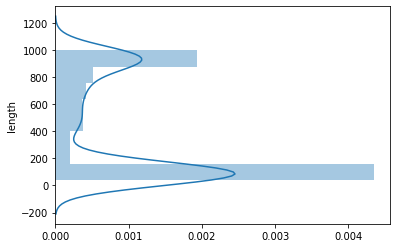

In [13]:

#Remove genes under 1kb in length
df_under1kb = df_final[df_final["length"]<1000]
ax = sns.distplot(df_under1kb["length"], vertical=True)

In [14]:
# Trim 1kb from 5p ends
df_over1kb = df_final[df_final["length"]>1000]
df_plu = df_over1kb[df_over1kb["strand"]=="+"]
df_min = df_over1kb[df_over1kb["strand"]=="-"]

df_plu["start"] = df_plu["start"] + 1000
df_min["stop"] = df_min["stop"] - 1000
df_trim = pd.concat([df_plu,df_min])
df_trim = df_trim.sort_values(ascending=True, by=["start","chr"])
toGTF(df=df_trim, name="hg38_refseq_noinside_trim1kb.gtf")

toBED(df=df_trim, name="hg38_refseq_noinside_trim1kb.bed")

In [15]:
df_inside_genes = df[~df["geneid"].isin(df_final["geneid"])]
toGTF(df=df_inside_genes, name="hg38_refseq_inside_genes.gtf")
print('len inside genes', len(df_inside_genes))
df_inside_genes.head()

len inside genes 2918


,chr,genome,type,start,zero,strand,dot,info,geneid,stop,length
5,chrM,hg38_ncbiRefSeq,exon,8527,0.0,+,.,"gene_id ""YP_003024031.1""; transcript_id ""YP_00...",YP_003024031.1,9207,680
6,chrM,hg38_ncbiRefSeq,exon,9207,0.0,+,0,"gene_id ""YP_003024032.1""; transcript_id ""YP_00...",YP_003024032.1,9990,783
9,chrM,hg38_ncbiRefSeq,exon,10760,0.0,+,.,"gene_id ""YP_003024035.1""; transcript_id ""YP_00...",YP_003024035.1,12137,1377
24,chr1,hg38_ncbiRefSeq,exon,17369,0.0,-,.,"gene_id ""NR_106918.1""; transcript_id ""NR_10691...",NR_106918.1,17436,67
50,chr12,hg38_ncbiRefSeq,exon,77376,0.0,+,.,"gene_id ""NM_015232.1""; transcript_id ""NM_01523...",NM_015232.1,171328,93952


In [16]:
# Convergent Transcription
# Opposite strand 3' overlaps

def Convergent(df, convergent_window):
    df_convergent = np.where((df["strand"] == "+") &
                             ( df["start"].shift(-1) >
                            
                            )
    
    return df


SyntaxError: invalid syntax (<ipython-input-16-b5c7c417bbca>, line 8)

### Genes inside other genes on opposite strand